In [2]:
%run Preprocessing.ipynb

# Model training

In [ ]:
!pip install dataframe_image
!pip install --upgrade pip
!pip install selenium
!pip install -U scikit-learn

In [48]:
sns.color_palette("mako", as_cmap=True)

# cm = sns.light_palette("seagreen", as_cmap=True)
# cs = sns.light_palette("royalblue", as_cmap=True)
cm = sns.light_palette("g", as_cmap=True)
cs = sns.light_palette("royalblue", as_cmap=True)


cols = ['Accuracy', 'Execution time', 'Std']
p = pd.DataFrame(np.random.randint(0,100,size=(9, 3)), columns=cols) 

p = p.style.background_gradient(cmap=cm, subset=['Accuracy'])\
               .background_gradient(cmap=cs, subset=['Std'])
display(HTML(p.to_html()))

,Accuracy,Execution time,Std
0,57,24,21
1,46,16,45
2,76,82,93
3,45,72,58
4,20,47,7
5,80,91,51
6,66,94,46
7,11,96,71
8,25,25,62


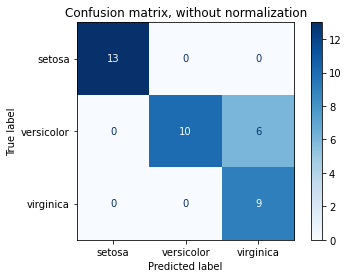

In [60]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

c = sns.color_palette("Blues", as_cmap=True)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None)
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=c,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()

In [6]:
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2, SelectPercentile

# import classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier

# model selection and metrics
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import sklearn.metrics as metrics

# import plot libs
import math
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
import dataframe_image as dfi

import time
import pickle

from selenium import webdriver
driver = webdriver.Chrome("C:/Users/matre/Downloads/chromedriver.exe")


rounds = 10
folds = 10
perc = "75"
path = "models_result/"+perc+"/"


def t_stat_interpret(t):
    """
    Takes a scalar and returns a string with
    the css property `'color: yellow'` for queue values, white otherwise.
    """

    # degrees of freedom
    p = 0.05
    df = rounds - 1
    t_table = pd.read_csv("./t_distribution_table.csv")
    c = float(t_table.loc[df, str(round(p / 2, 3))])

    if t == "":
        color = 'white'
    else:
        #color = 'white' if t > c or t < -c else 'yellow'
        color = 'pink' if t > c or t < -c else 'lightgreen'
    return 'background: % s' % color


def scoring(pipeline, data, labels, iter):
    results_10CV = []

    # start iter
    for i in range(1, iter + 1):
        X, y = shuffle(data, labels, random_state=i * 42)
        results_10CV.append(np.mean(cross_val_score(estimator=pipeline,
                                                    X=X,
                                                    y=y,
                                                    cv=10,
                                                    n_jobs=-1
                                                    )))

    return results_10CV


# ------------------------ 10-fold cross validation ------------------------

def cross_validation(models, tweets, targets):

    # properties for new dataframe
    idx = (model['name'] for model in models)
    cols = ['Accuracy', 'Execution time', 'Std']
    cvs = pd.DataFrame(np.zeros((11, 3)), columns=cols, index=idx)
    # cm variable by the color palette from seaborn
    cm = sns.light_palette("g", as_cmap=True)
    cs = sns.light_palette("royalblue", as_cmap=True)

    for model in models:
        start = time.time()

        model['pipeline'] = Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 1))),
                                            ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
                                            ('fselect', SelectPercentile(chi2, percentile=int(perc))),
                                            ('clf', model['fun'])])

        model['values'] = scoring(model['pipeline'], tweets, targets, rounds)

        end = time.time()

        cvs.loc[model['name']] = [float(("%.6f" % np.mean(model['values'])).rstrip('0').rstrip('.')), \
                                  str(round((end - start),4))+" s", \
                                  float("%.6f" % np.std(model['values']))]
        cvs.sort_values('Accuracy', inplace=True, ascending=False)

    print("\nCross validation results:\n")
    cvs.to_csv(path+"training_result_"+perc+"/cross_val_result.csv")
    
    cvs = cvs.style.background_gradient(cmap=cm, subset=['Accuracy'])\
                   .background_gradient(cmap=cs, subset=['Std'])
    dfi.export(cvs, path+"training_result_"+perc+"/cross_val_result.png")
    display(HTML(cvs.to_html()))

    # discarded for execution time
    discarded = ["Bagging", "Random Forest", "Gradient Boosting"]
    # discarded for accuracy
    discarded.extend(["K Nearest", "Decision Tree", "Ada Boost", \
                      "Stochastic Gradient"])
    return discarded

# ----------------- t-test evaluation from library -------------------------

def t_test(models_selected):

    all_t_stat = []

    i = 0
    j = 0
    for model in models_selected:
        row = []
        i += 1
        j = 0
        for another_model in models_selected:
            j += 1
            if (j < i + 1):
                row.append("")
                continue
            t_statistic, p_value = stats.ttest_rel(model['values'], \
                                                   another_model['values'])
            # print(t_statistic, p_value)
            row.append(t_statistic)

        all_t_stat.append(row)

    print("\nT-test results:\n")

    ttest_matrix = pd.DataFrame(all_t_stat, 
                                columns=(model['name'] for model in models_selected),
                                index=(model['name'] for model in models_selected))
    #delete empty column and row
    del ttest_matrix['Logistic Regression']
    ttest_matrix.drop(ttest_matrix.tail(1).index,inplace=True)
    
    ttest_matrix.to_csv(path+"training_result_"+perc+"/t_test_result.csv")
    ttest_matrix = ttest_matrix.style.applymap(t_stat_interpret)
    dfi.export(ttest_matrix, path+"training_result_"+perc+"/t_test_result.png")
    display(HTML(ttest_matrix.to_html()))

    discarded = []
    discarded.append("SVM")

    return discarded


# ---------------------- report and confusion matrix ----------------------- 

def get_report_conf_matrix(models, tweets, targets):

    print("\nReport and confusion matrix")

    for model in models:
        
        print(model['name'])
        predict = cross_val_predict(model['pipeline'], tweets, targets, cv=10)
        rep = metrics.classification_report(targets, predict,
                                            target_names=['0', '1'])
        print(rep)
      
        # save report
        rep = metrics.classification_report(targets, predict,
                                    target_names=['0', '1'], output_dict=True)
        df = pd.DataFrame(rep)
        df.to_csv(path+'training_result_'+perc+'/'+model['name']+'-report.csv')
        
        # calculate and print confusion matrix
        disp = ConfusionMatrixDisplay.from_predictions(
            targets,
            predict,
            values_format='g',
            display_labels=[0,1],
            cmap=plt.cm.Blues
        )
        disp.ax_.set_title("Confusion matrix")

        print(disp.confusion_matrix)
        disp.figure_.savefig(path+'training_result_'+perc+'/'+model['name']+'-confusion_matrix.png')
        
        print("\n")


def train_models(data):

    data.sample(frac=1)

    tweets = data.text
    targets = data.target

    # models = name | fun | pipeline | values |
    models = [
        {"name": "Logistic Regression", "fun": LogisticRegression()},
        {"name": "SVM", "fun": svm.SVC()},
        {"name": "Decision Tree", "fun": DecisionTreeClassifier()},
        {"name": "MultinomialNB", "fun": MultinomialNB()},
        {"name": "Gradient Boosting", "fun": GradientBoostingClassifier()},
        {"name": "ComplementNB", "fun": ComplementNB()},
        {"name": "K Nearest", "fun": KNeighborsClassifier()},
        {"name": "Random Forest", "fun": RandomForestClassifier()},
        {"name": "Ada Boost", "fun": AdaBoostClassifier()},
        {"name": "Bagging", "fun": BaggingClassifier()},
        {"name": "Stochastic Gradient", "fun": SGDClassifier()}
    ]

    # analyze classifiers

    discarded = cross_validation(models, tweets, targets)

    models_selected = [s for s in models if s['name'] not in discarded]

    discarded = t_test(models_selected)

    models_selected = [s for s in models_selected if s['name'] not in discarded]

    get_report_conf_matrix(models, tweets, targets)


    # models building

    for model in models_selected:
      
        m = model['pipeline'].fit(tweets, targets)
        
        # save models
        filename = model['name'] + '.sav'
        pickle.dump(m, open(path+'models_'+perc+'/'+filename, 'wb'))

    print("\nModels correctly saved!")


C:\Users\matre\AppData\Local\Temp\ipykernel_5504\12406874.py:38: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("C:/Users/matre/Downloads/chromedriver.exe")


# Training flow

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matre\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Preprocessing done
Elaboration done



Cross validation results:



C:\Users\matre\anaconda3\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,Accuracy,Execution time,Std
ComplementNB,0.722707,0.8433 s,0.004399
MultinomialNB,0.721561,0.7804 s,0.005267
Logistic Regression,0.720304,4.1702 s,0.003269
SVM,0.717701,4.3656 s,0.004545
Stochastic Gradient,0.698604,0.7955 s,0.005700
Random Forest,0.694788,12.39 s,0.009920
Gradient Boosting,0.689087,8.7442 s,0.005444
Bagging,0.678003,12.7349 s,0.010078
Ada Boost,0.670812,3.6002 s,0.008493
Decision Tree,0.652599,2.8064 s,0.010697



T-test results:



C:\Users\matre\anaconda3\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,SVM,MultinomialNB,ComplementNB
Logistic Regression,1.592327,-0.651762,-1.448561
SVM,,-2.159805,-3.053071
MultinomialNB,,,-2.108346



Report and confusion matrix
Logistic Regression
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       788
           1       0.74      0.69      0.71       788

    accuracy                           0.73      1576
   macro avg       0.73      0.73      0.72      1576
weighted avg       0.73      0.73      0.72      1576

[[600 188]
 [245 543]]


SVM
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       788
           1       0.73      0.69      0.71       788

    accuracy                           0.72      1576
   macro avg       0.72      0.72      0.72      1576
weighted avg       0.72      0.72      0.72      1576

[[587 201]
 [244 544]]


Decision Tree
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       788
           1       0.65      0.64      0.65       788

    accuracy                           0.65      1576
   macro av

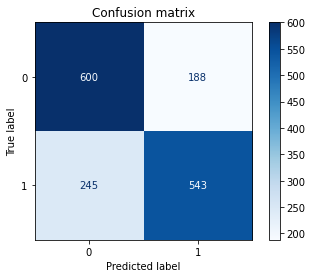

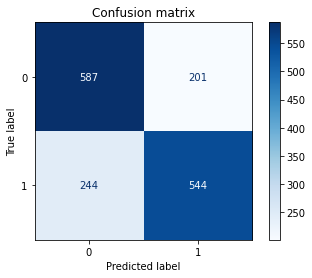

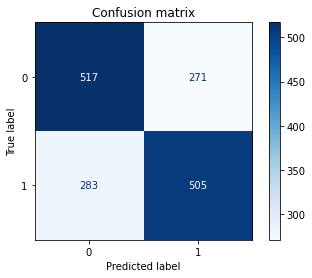

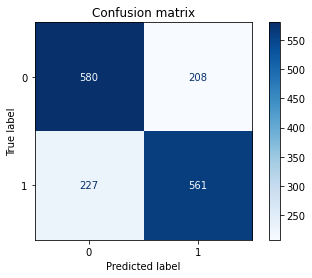

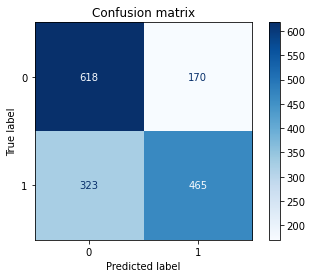

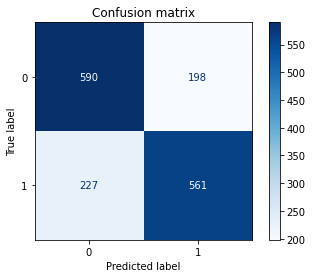

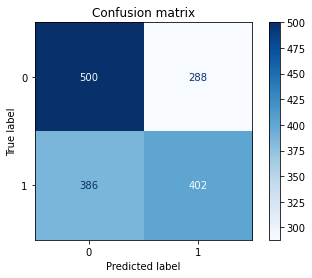

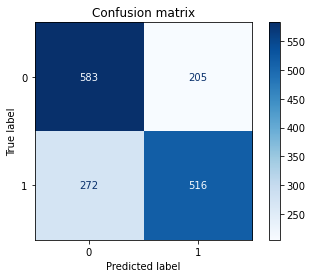

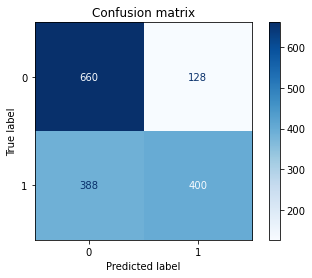

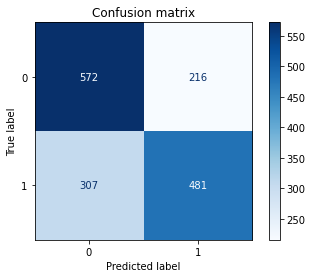

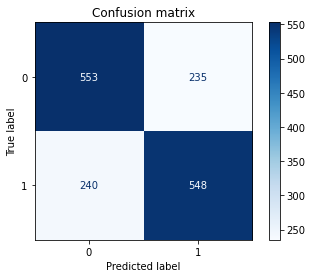

In [10]:
import pandas as pd
import nltk
from IPython.display import HTML
from sklearn.feature_extraction.text import CountVectorizer


if __name__ == '__main__':
    
    training_set_file = 'labeled/2021-12-01-labeled-only.csv'
    train_data = pd.read_csv(training_set_file, index_col=False, delimiter=",")

    train_data = preprocess(train_data)
    train_data = elaborate(train_data)

    # print(train_data.shape)
    #tot0 = len(train_data[train_data.target == '0'])
    #tot1 = len(train_data[train_data.target == '1'])

    train_models(train_data)

# Model testing

In [4]:
from sklearn.utils import shuffle
import time
import numpy as np
import pandas as pd
from scipy import stats
import pickle

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2, SelectPercentile

# import classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier

# model selection and metrics
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

# import plot libs
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML


def test_models(data):

    tweets = data['text']
    targets = data['target']

    models = [
        {"name": "MultinomialNB", "fun": MultinomialNB()},
        {"name": "Logistic Regression", "fun": LogisticRegression()},
        {"name": "ComplementNB", "fun": ComplementNB()}
    ]

    # load the model from disk
    for model in models:

        loaded_model = pickle.load(open(path+'models_'+perc+'/'+model['name']+'.sav', 'rb'))
        print(model['name'])
        score = loaded_model.score(tweets, targets)
        print("Test score: {0:.2f} %".format(100 * score))
        y_predict = loaded_model.predict(tweets)

        rep = classification_report(targets, y_predict,
                                              target_names=['0', '1'])
        print(rep, '\n')

        # save reports
        rep = classification_report(targets, y_predict,
                                    target_names=['0', '1'], output_dict=True)
        df = pd.DataFrame(rep).transpose()
        df.to_csv(path+'test_result_'+perc+'/'+model['name']+'-report.csv')


# Test flow

In [7]:
import pandas as pd
import nltk
from IPython.display import HTML
from sklearn.feature_extraction.text import CountVectorizer

if __name__ == '__main__':
    
    test_set_file = './labeled/2022-02-labeled-only.csv'
    test_data = pd.read_csv(test_set_file, index_col=False, delimiter=",")
    
    test_data = preprocess(test_data)
    test_data = elaborate(test_data)

    # print(test_data.shape)
    #tot0 = len(train_data[test_data.target == '0'])
    #tot1 = len(train_data[test_data.target == '1'])

    test_models(test_data)
    #we consider just yellow -> null hp non rejected -> similar to each other -> best Complement e Logistic? Migliori accuracy e execution time

Preprocessing done
Elaboration done


MultinomialNB
Test score: 73.30 %
              precision    recall  f1-score   support

           0       0.71      0.78      0.75        88
           1       0.76      0.68      0.72        88

    accuracy                           0.73       176
   macro avg       0.74      0.73      0.73       176
weighted avg       0.74      0.73      0.73       176
 

Logistic Regression
Test score: 71.59 %
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        88
           1       0.76      0.62      0.69        88

    accuracy                           0.72       176
   macro avg       0.72      0.72      0.71       176
weighted avg       0.72      0.72      0.71       176
 

ComplementNB
Test score: 73.30 %
              precision    recall  f1-score   support

           0       0.71      0.78      0.75        88
           1       0.76      0.68      0.72        88

    accuracy                     